First basic tests:
* No special color profiles of Canon cameras
* Scaled down, square images
* Faces not obstructed, no sunglasses
* Typing everywhere

In [14]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import typing

<Figure size 900x300 with 0 Axes>

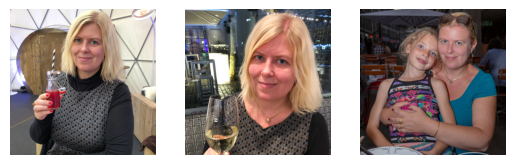

In [22]:
img1_name: str = 'test_files/test-image-carolien-montreux-2018.jpg'
img2_name: str = 'test_files/test-image-carolien-geneva-2018.jpg'
img3_name: str = 'test_files/test-image-carolien-bern-2018-with-child.jpg'

def show_single_image(filename: str) -> None:
  """ Show an image with matplotlib in a notebook """
  img: np.ndarray = plt.imread(filename)
  plt.figure(figsize=(3.,3.))
  plt.imshow(img)

def show_images_in_row(filenames: typing.List[str]) -> None:
  """ show multiple images in a row """
  plt.figure(figsize=(len(filenames)*3., 3.))
  _, _axes = plt.subplots(1, len(filenames))
  axes: typing.List[Axes] = typing.cast(typing.List[Axes], _axes)
  for i, filename in enumerate(filenames):
    axes[i].set_axis_off()
    img: np.ndarray = plt.imread(filename)
    axes[i].imshow(img)

show_images_in_row([img1_name, img2_name, img3_name])

TypeError: represent() missing 1 required positional argument: 'img_path'